# **Comparative Analysis of European Option Pricing using Binomial Trees and Black-Scholes Model**

First we import the necessary libraries


In [1]:
import numpy as np
import pandas as pd
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

Henceforth we stick to these terms:

- $S$: Current stock price  
- $K$: Strike price  
- $T$: Time to maturity (in years)  
- $r$: Risk-free interest rate (annual)  
- $\sigma$: Volatility of the stock (standard deviation)  

Also all the prices mentioned here is in dollars.

## **Binomial Tree model**

The Cox-Ross-Rubinstein binomial model is a discrete-time method for pricing options that builds a recombining price tree. Given there are $N$ time steps, in each small time step $\Delta t = \frac{T}{N}$, the stock moves up by factor $u = e^{\sigma \sqrt{\Delta t}}$ or down by $d = \frac{1}{u}$. Under risk-neutral pricing, the up-probability is

$$p = \frac{e^{r \Delta t} - d}{u - d}$$

We then compute option values by backward induction: at maturity the payoffs are $\max(S_i- K, 0)$ for call option and $\max(K - S_i, 0)$ for put option, where $S_i = S u^{i} d^{N-i}$ is the total stock price after $i$ up movements. We then compute the expected option prices in a backward manner.

Assumptions:

* This is a discrete time model and simplification of real world stock movement: for each small time interval, the stock goes up by factor of $u$ or down by factor of $d$.
* No arbitrage oppurtunities.

This model also works when volatility and risk free interest rate are not constant and when the asset pays dividends, and for both European and American options (in contrast to Black Scholes Model).



In [2]:
def binomial_tree_model(S, K, T, r, sigma, N, option):
    dt = T/N
    u = exp(sigma * sqrt(dt))
    d = 1/u
    p = (exp(r*dt) - d) / (u - d)
    prices = [S * (u**i) * (d**(N-i)) for i in range(N, -1, -1)]

    if option == 'call':
        values = [max(s - K, 0) for s in prices]
    else:
        values = [max(K - s, 0) for s in prices]

    for i in range(N-1, -1, -1):
        values = [exp(-r*dt) * (p * values[j] + (1-p) * values[j+1]) for j in range(i+1)]

    return values[0]

## **Binomial Tree Model Sensitivity**

We write a function to plot binomial tree model's sensitivity against key parameters $K, T, r, \sigma$.

In [3]:
def binomial_tree_sensitivity(param_name, param_range, S, K, T, r, sigma, N, option, ax):
    prices = []
    for param in param_range:
        if param_name == 'sigma':
            prices.append(binomial_tree_model(S, K, T, r, param, N, option))
        elif param_name == 'T':
            prices.append(binomial_tree_model(S, K, param, r, sigma, N, option))
        elif param_name == 'r':
            prices.append(binomial_tree_model(S, K, T, param, sigma, N, option))
        elif param_name == 'K':
            prices.append(binomial_tree_model(S, param, T, r, sigma, N, option))

    ax.plot(param_range, prices, 'r', label='Black-Scholes')
    if(param_name == 'sigma'):
        param_name = 'sigma ($\sigma$)'
    ax.set_xlabel(param_name)
    ax.set_ylabel('Option Price')
    ax.grid(True)

We fix the initial values of $S, K, T, r, \sigma, N$ and vary the key parameters for both call and put options, and plot the results.

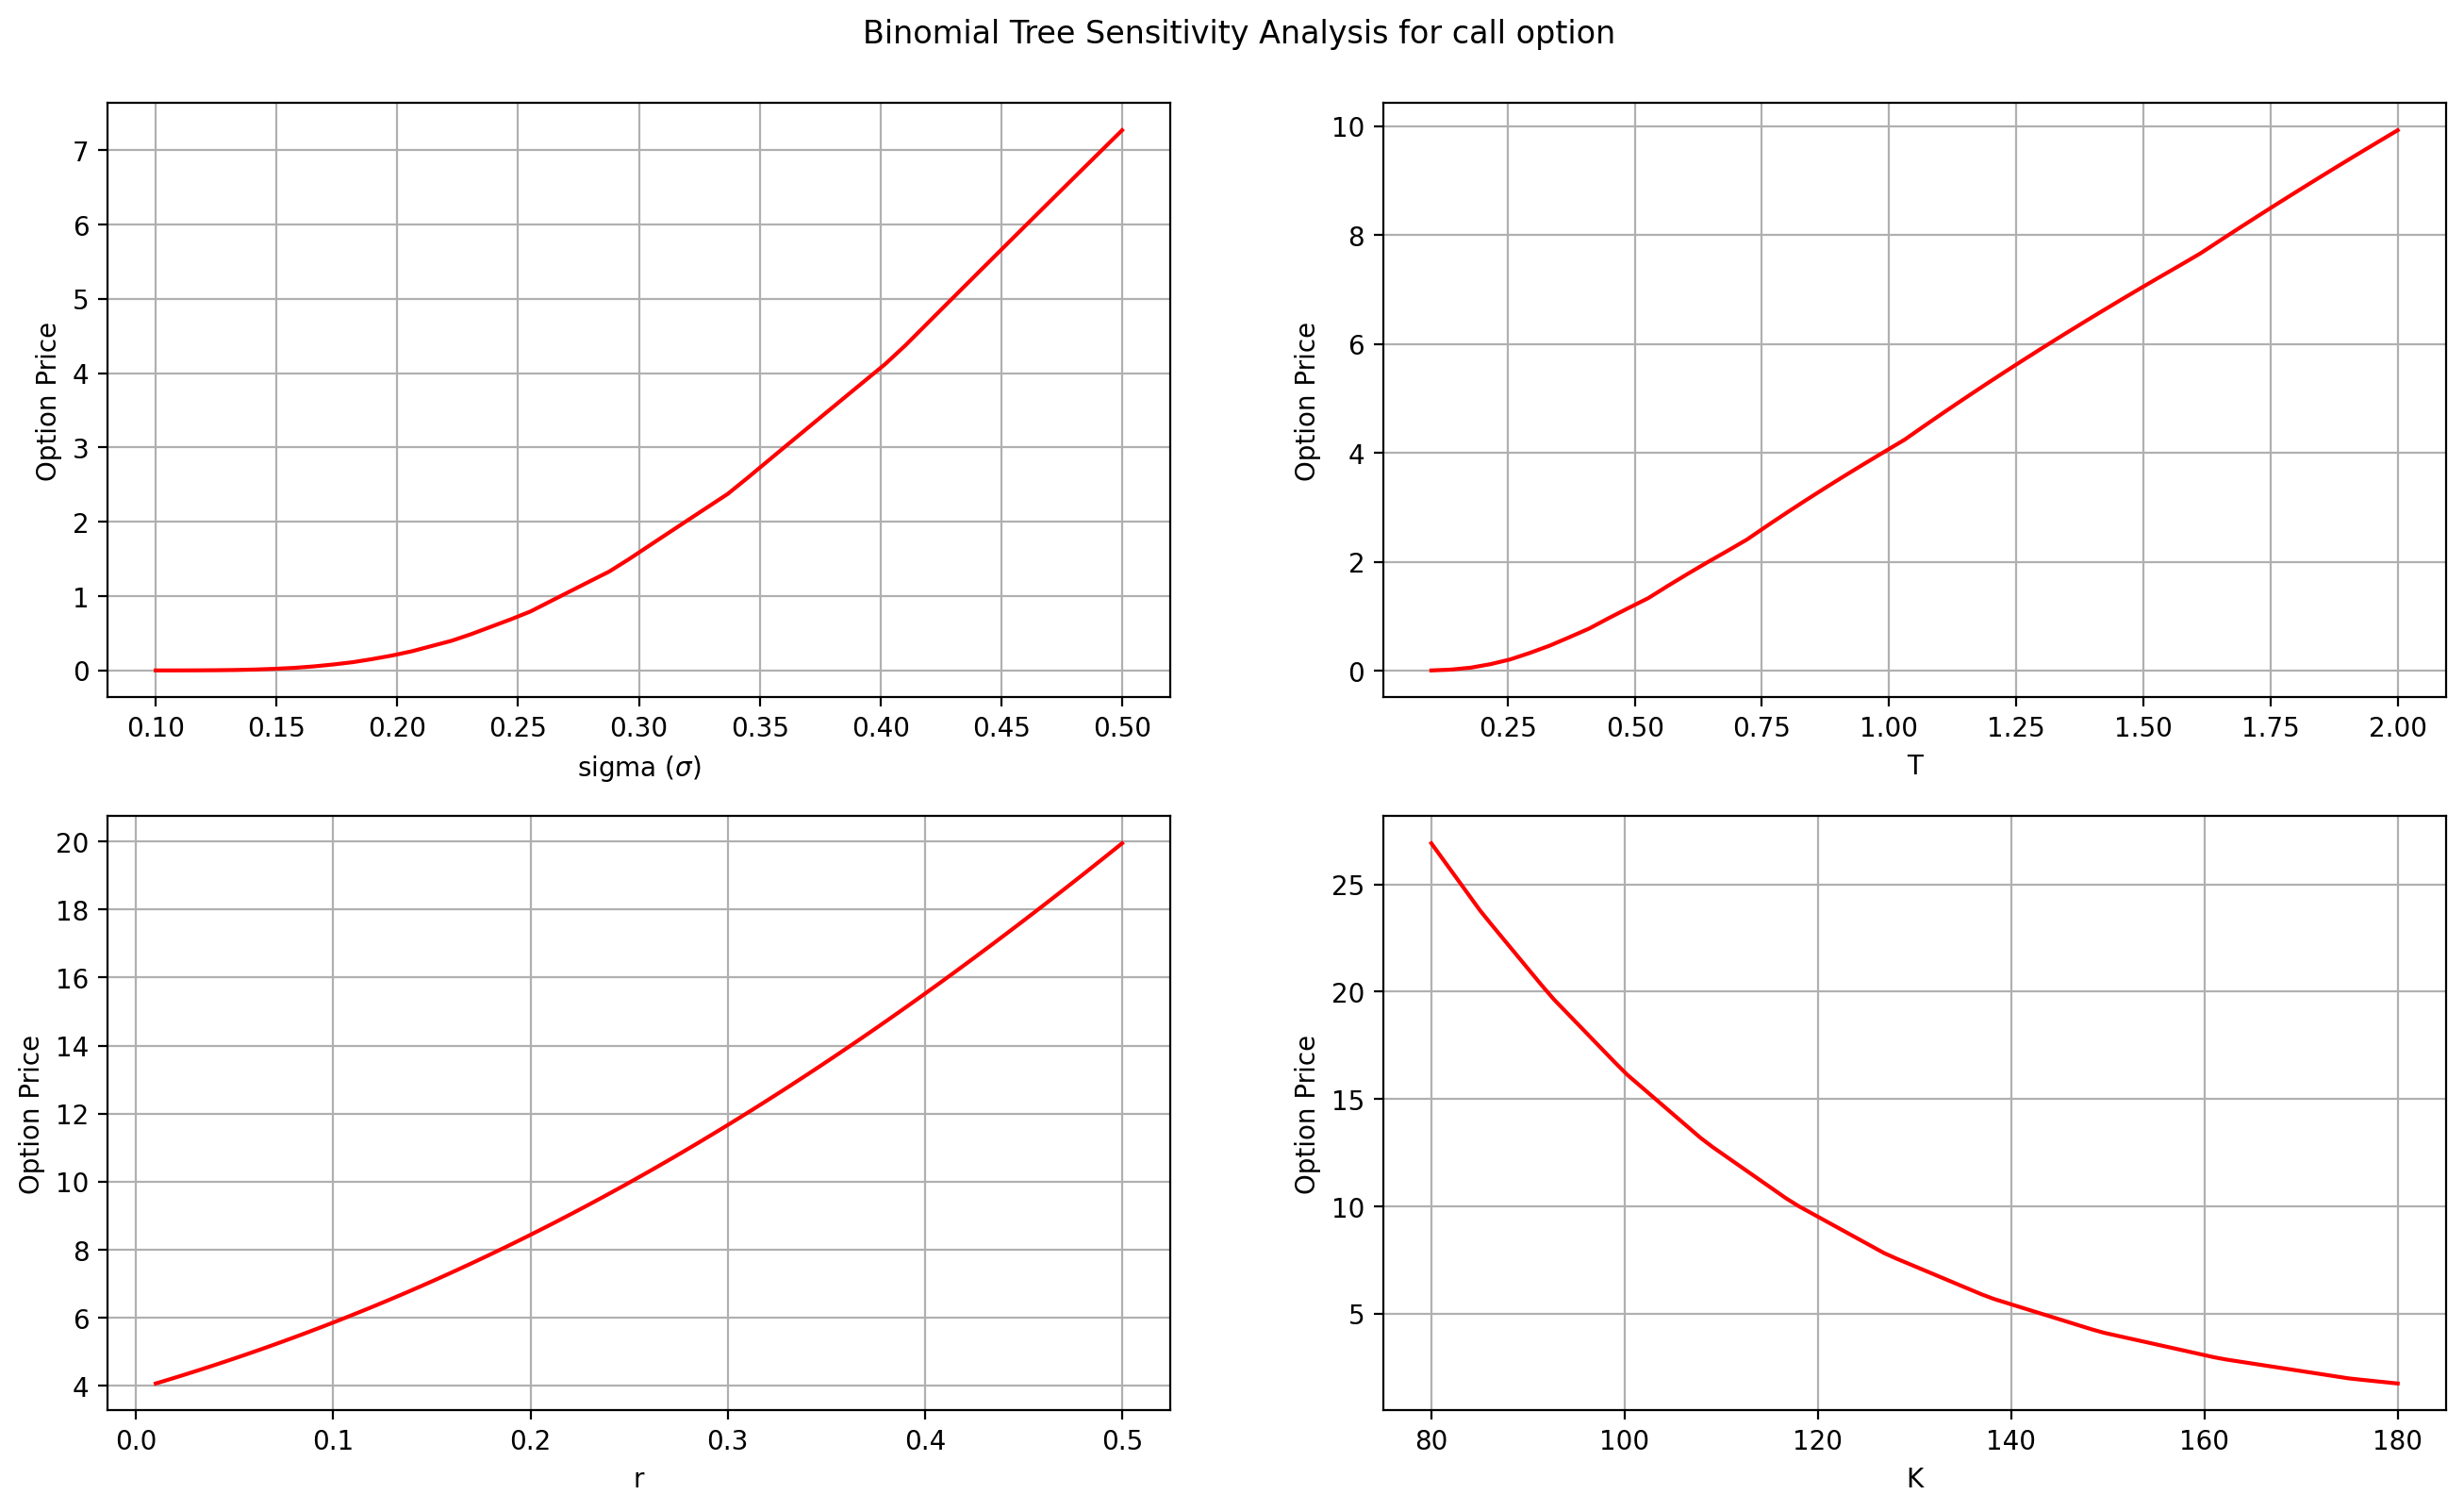

In [4]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4
N = 100

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
binomial_tree_sensitivity('sigma', volatility_range, S, K, T, r, sigma, N, 'call', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
binomial_tree_sensitivity('T', time_range, S, K, T, r, sigma, N, 'call', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
binomial_tree_sensitivity('r', rate_range, S, K, T, r, sigma, N, 'call', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
binomial_tree_sensitivity('K', strike_range, S, K, T, r, sigma, N, 'call', axs[1, 1])

fig.suptitle(r'Binomial Tree Sensitivity Analysis for call option', y=0.93)
plt.show()

We see that for call option, option price increases as $\sigma, T, r$ increases and decreases as $K$ increases.

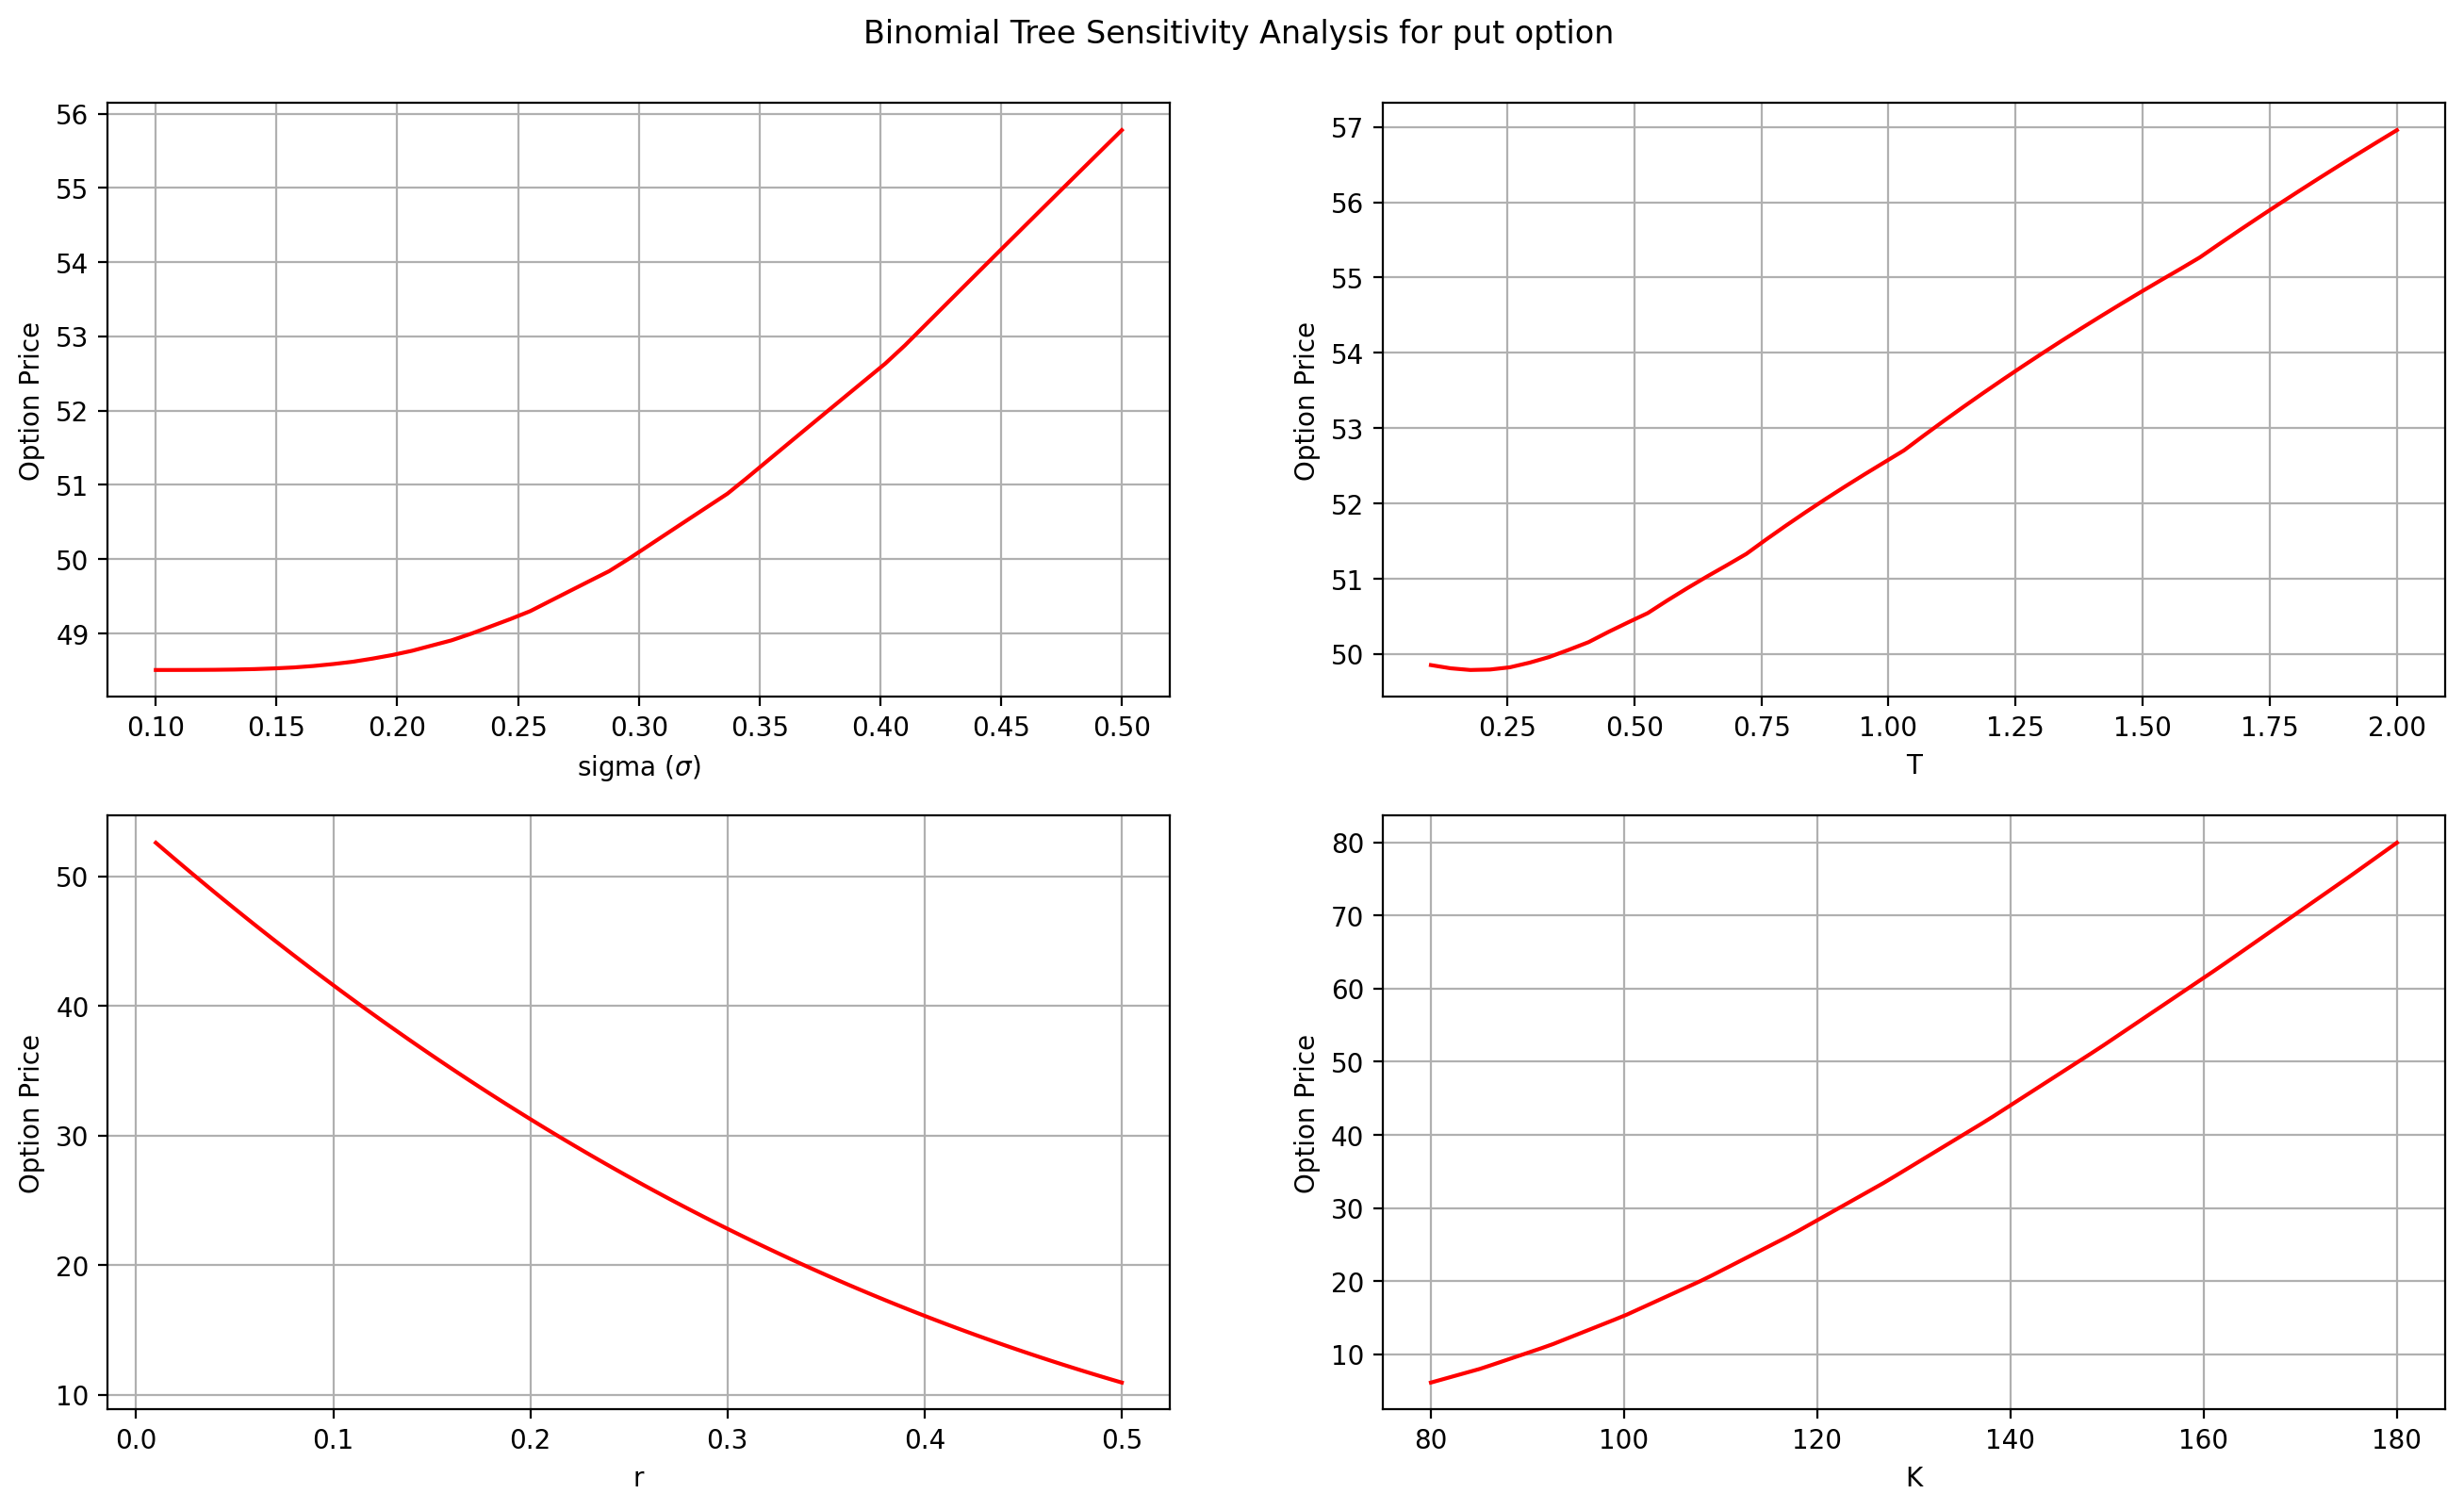

In [5]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4
N = 100

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
binomial_tree_sensitivity('sigma', volatility_range, S, K, T, r, sigma, N, 'put', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
binomial_tree_sensitivity('T', time_range, S, K, T, r, sigma, N, 'put', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
binomial_tree_sensitivity('r', rate_range, S, K, T, r, sigma, N, 'put', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
binomial_tree_sensitivity('K', strike_range, S, K, T, r, sigma, N, 'put', axs[1, 1])

fig.suptitle(r'Binomial Tree Sensitivity Analysis for put option', y=0.93)
plt.show()

We see that for put option, option price increases as $\sigma, T, K$ increases and decreases as $r$ increases in this case.

## **Black-Scholes Model**

The Black-Scholes Model is a mathematical model for pricing European options. It provides a closed-form formula to compute the fair price of a call or put option.

The equations are:

$$ d_1 = \frac{\ln(S / K) + \left( r + \sigma^2/2 \right) T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T} $$

Then we calculate call option price $C$ and put option price $P$:

$$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2) $$

$$ P = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1) $$

where $N(x)$: Cumulative distribution function of the standard normal distribution.

Assumptions:

* This is a continuous time based model.
* Log returns are normally distributed.
* The volatility and risk free interest rate are constant.
* No Arbitrage opportunities.
* Cannot be used when the asset pays dividends.
* Works only for European options.

We now implement the black scholes model:

In [6]:
def black_scholes_model(S, K, T, r, sigma, option):
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if option == 'call':
        price = S * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)
    else:
        price = K * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

## **Option Greeks**

The option greeks based on Black-Scholes Model are as follows:

* **Delta:** Sensitivity of the option's price to a small change in the underlying stock price.

$$ \Delta_{\text{call}} = N(d_1), \quad \Delta_{\text{put}} = -N(-d_1) $$

* **Gamma:** Sensitivity of Delta to changes in the stock price.

$$ \Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}} $$

* **Vega:** Sensitivity of the option's price to changes in volatility.

$$\text{Vega} = S \cdot N'(d_1) \cdot \sqrt{T}$$

* **Theta:** Sensitivity of the option's price to time decay.

$$ \Theta_{\text{call}} = \frac{-S N'(d_1) \sigma}{2 \sqrt{T}} - rK e^{-rT} N(d_2), \quad \Theta_{\text{put}} = \frac{-S N'(d_1) \sigma}{2 \sqrt{T}} + rK e^{-rT} N(-d_2)$$

* **Rho:** Sensitivity of the option's price to changes in the risk-free interest rate.

$$ \rho_{\text{call}} = K T e^{-rT} N(d_2), \quad \rho_{\text{put}} = -K T e^{-rT} N(-d_2)$$

Here $N'(x)$ is pdf of standard normal distribution, and other symbols have their usual meanings.


We now write a function to calculate the greeks.

In [7]:
def black_scholes_greeks(S, K, T, r, sigma, option):
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    nd1 = norm.pdf(d1)

    if option == 'call':
        delta = norm.cdf(d1)
        theta = -(S * nd1 * sigma) / (2 * sqrt(T)) - r * K * exp(-r*T) * norm.cdf(d2)
        rho   = K * T * exp(-r*T) * norm.cdf(d2)
    else:
        delta = -norm.cdf(-d1)
        theta = -(S * nd1 * sigma) / (2 * sqrt(T)) + r * K * exp(-r*T) * norm.cdf(-d2)
        rho   = -K * T * exp(-r*T) * norm.cdf(-d2)

    gamma = nd1 / (S * sigma * sqrt(T))
    vega  = S * sqrt(T) * nd1

    return {'Delta': delta, 'Gamma': gamma, 'Theta': theta, 'Vega': vega, 'Rho': rho}

## **Black-Scholes model sensitivity**

We write a function to plot Black-Scholes model sensitivity against key parameters $K, T, r, \sigma$.

In [8]:
def black_scholes_sensitivity(param_name, param_range, S, K, T, r, sigma, option, ax):
    prices = []
    for param in param_range:
        if param_name == 'sigma':
            prices.append(black_scholes_model(S, K, T, r, param, option))
        elif param_name == 'T':
            prices.append(black_scholes_model(S, K, param, r, sigma, option))
        elif param_name == 'r':
            prices.append(black_scholes_model(S, K, T, param, sigma, option))
        elif param_name == 'K':
            prices.append(black_scholes_model(S, param, T, r, sigma, option))

    ax.plot(param_range, prices, label='Black-Scholes')
    if(param_name == 'sigma'):
        param_name = 'sigma ($\sigma$)'
    ax.set_xlabel(param_name)
    ax.set_ylabel('Option Price')
    ax.grid(True)

We fix the initial values of $S, K, T, r, \sigma$ and vary the key parameters for both call and put options, and plot the results.

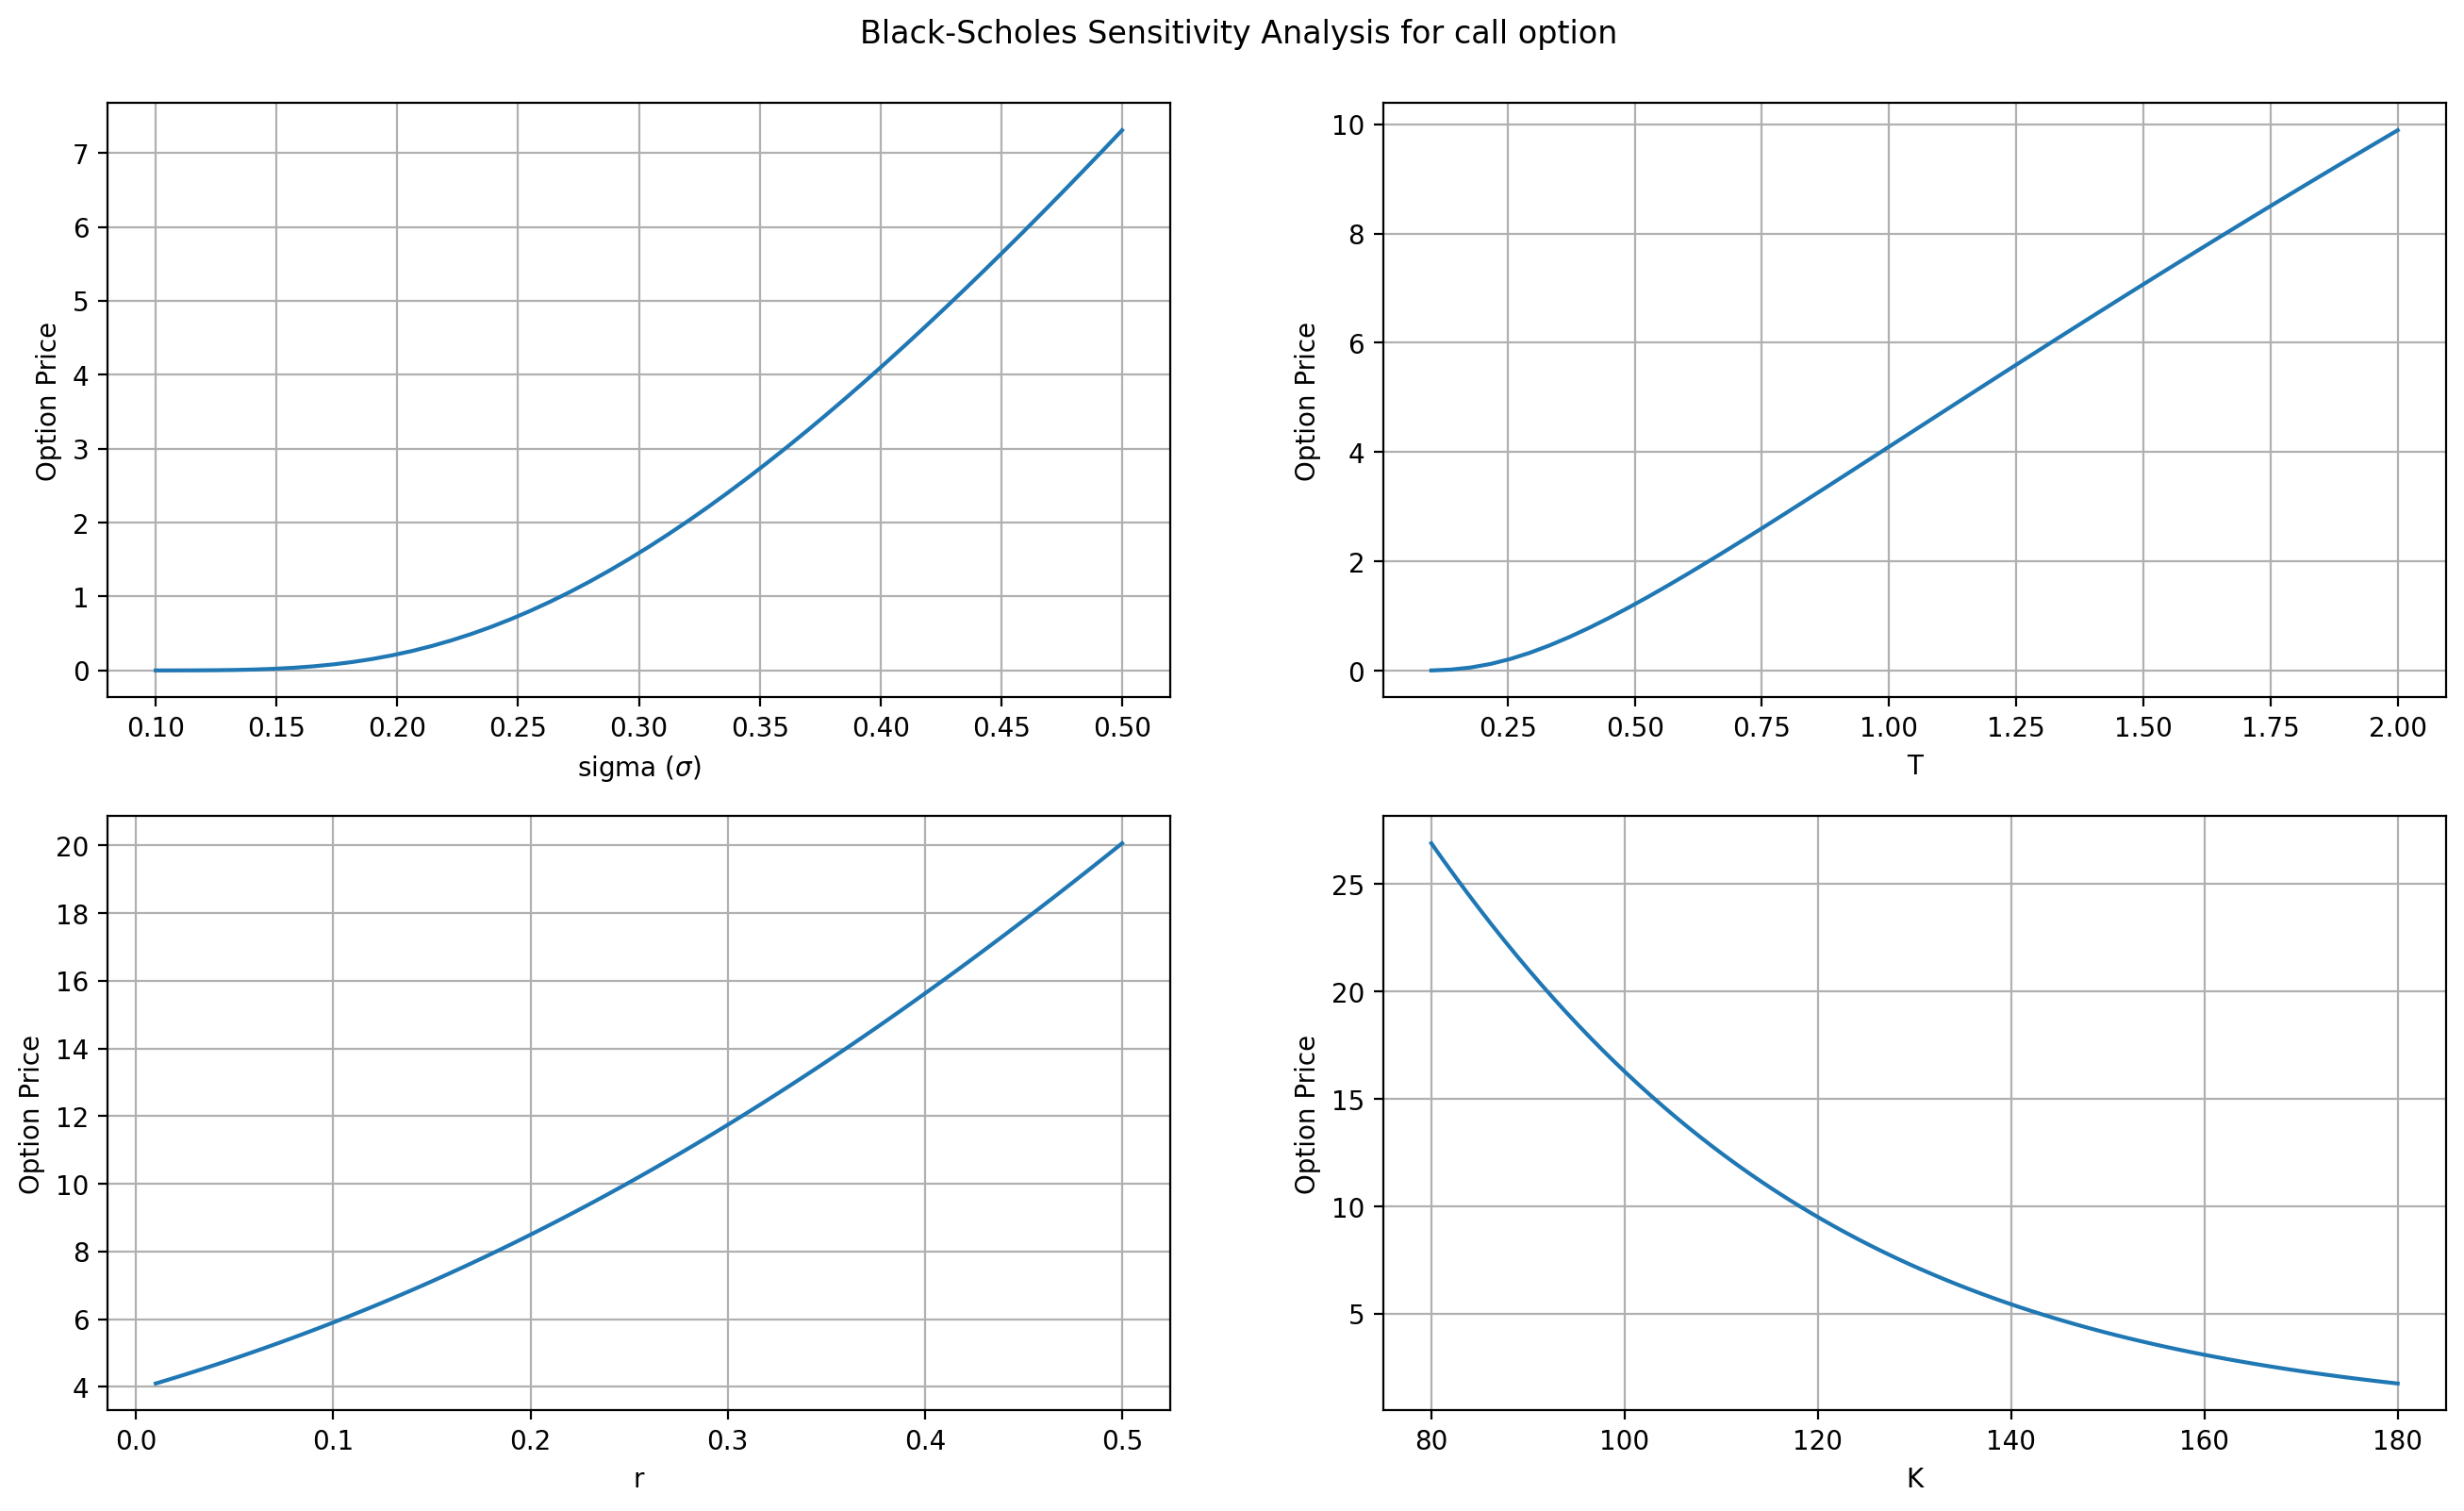

In [9]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
black_scholes_sensitivity('sigma', volatility_range, S, K, T, r, sigma, 'call', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
black_scholes_sensitivity('T', time_range, S, K, T, r, sigma, 'call', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
black_scholes_sensitivity('r', rate_range, S, K, T, r, sigma, 'call', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
black_scholes_sensitivity('K', strike_range, S, K, T, r, sigma, 'call', axs[1, 1])

fig.suptitle(r'Black-Scholes Sensitivity Analysis for call option', y=0.93)
plt.show()

Similar to binomial tree model, we see that for call option, option price increases as $\sigma, T, r$ increases and decreases as $K$ increases.

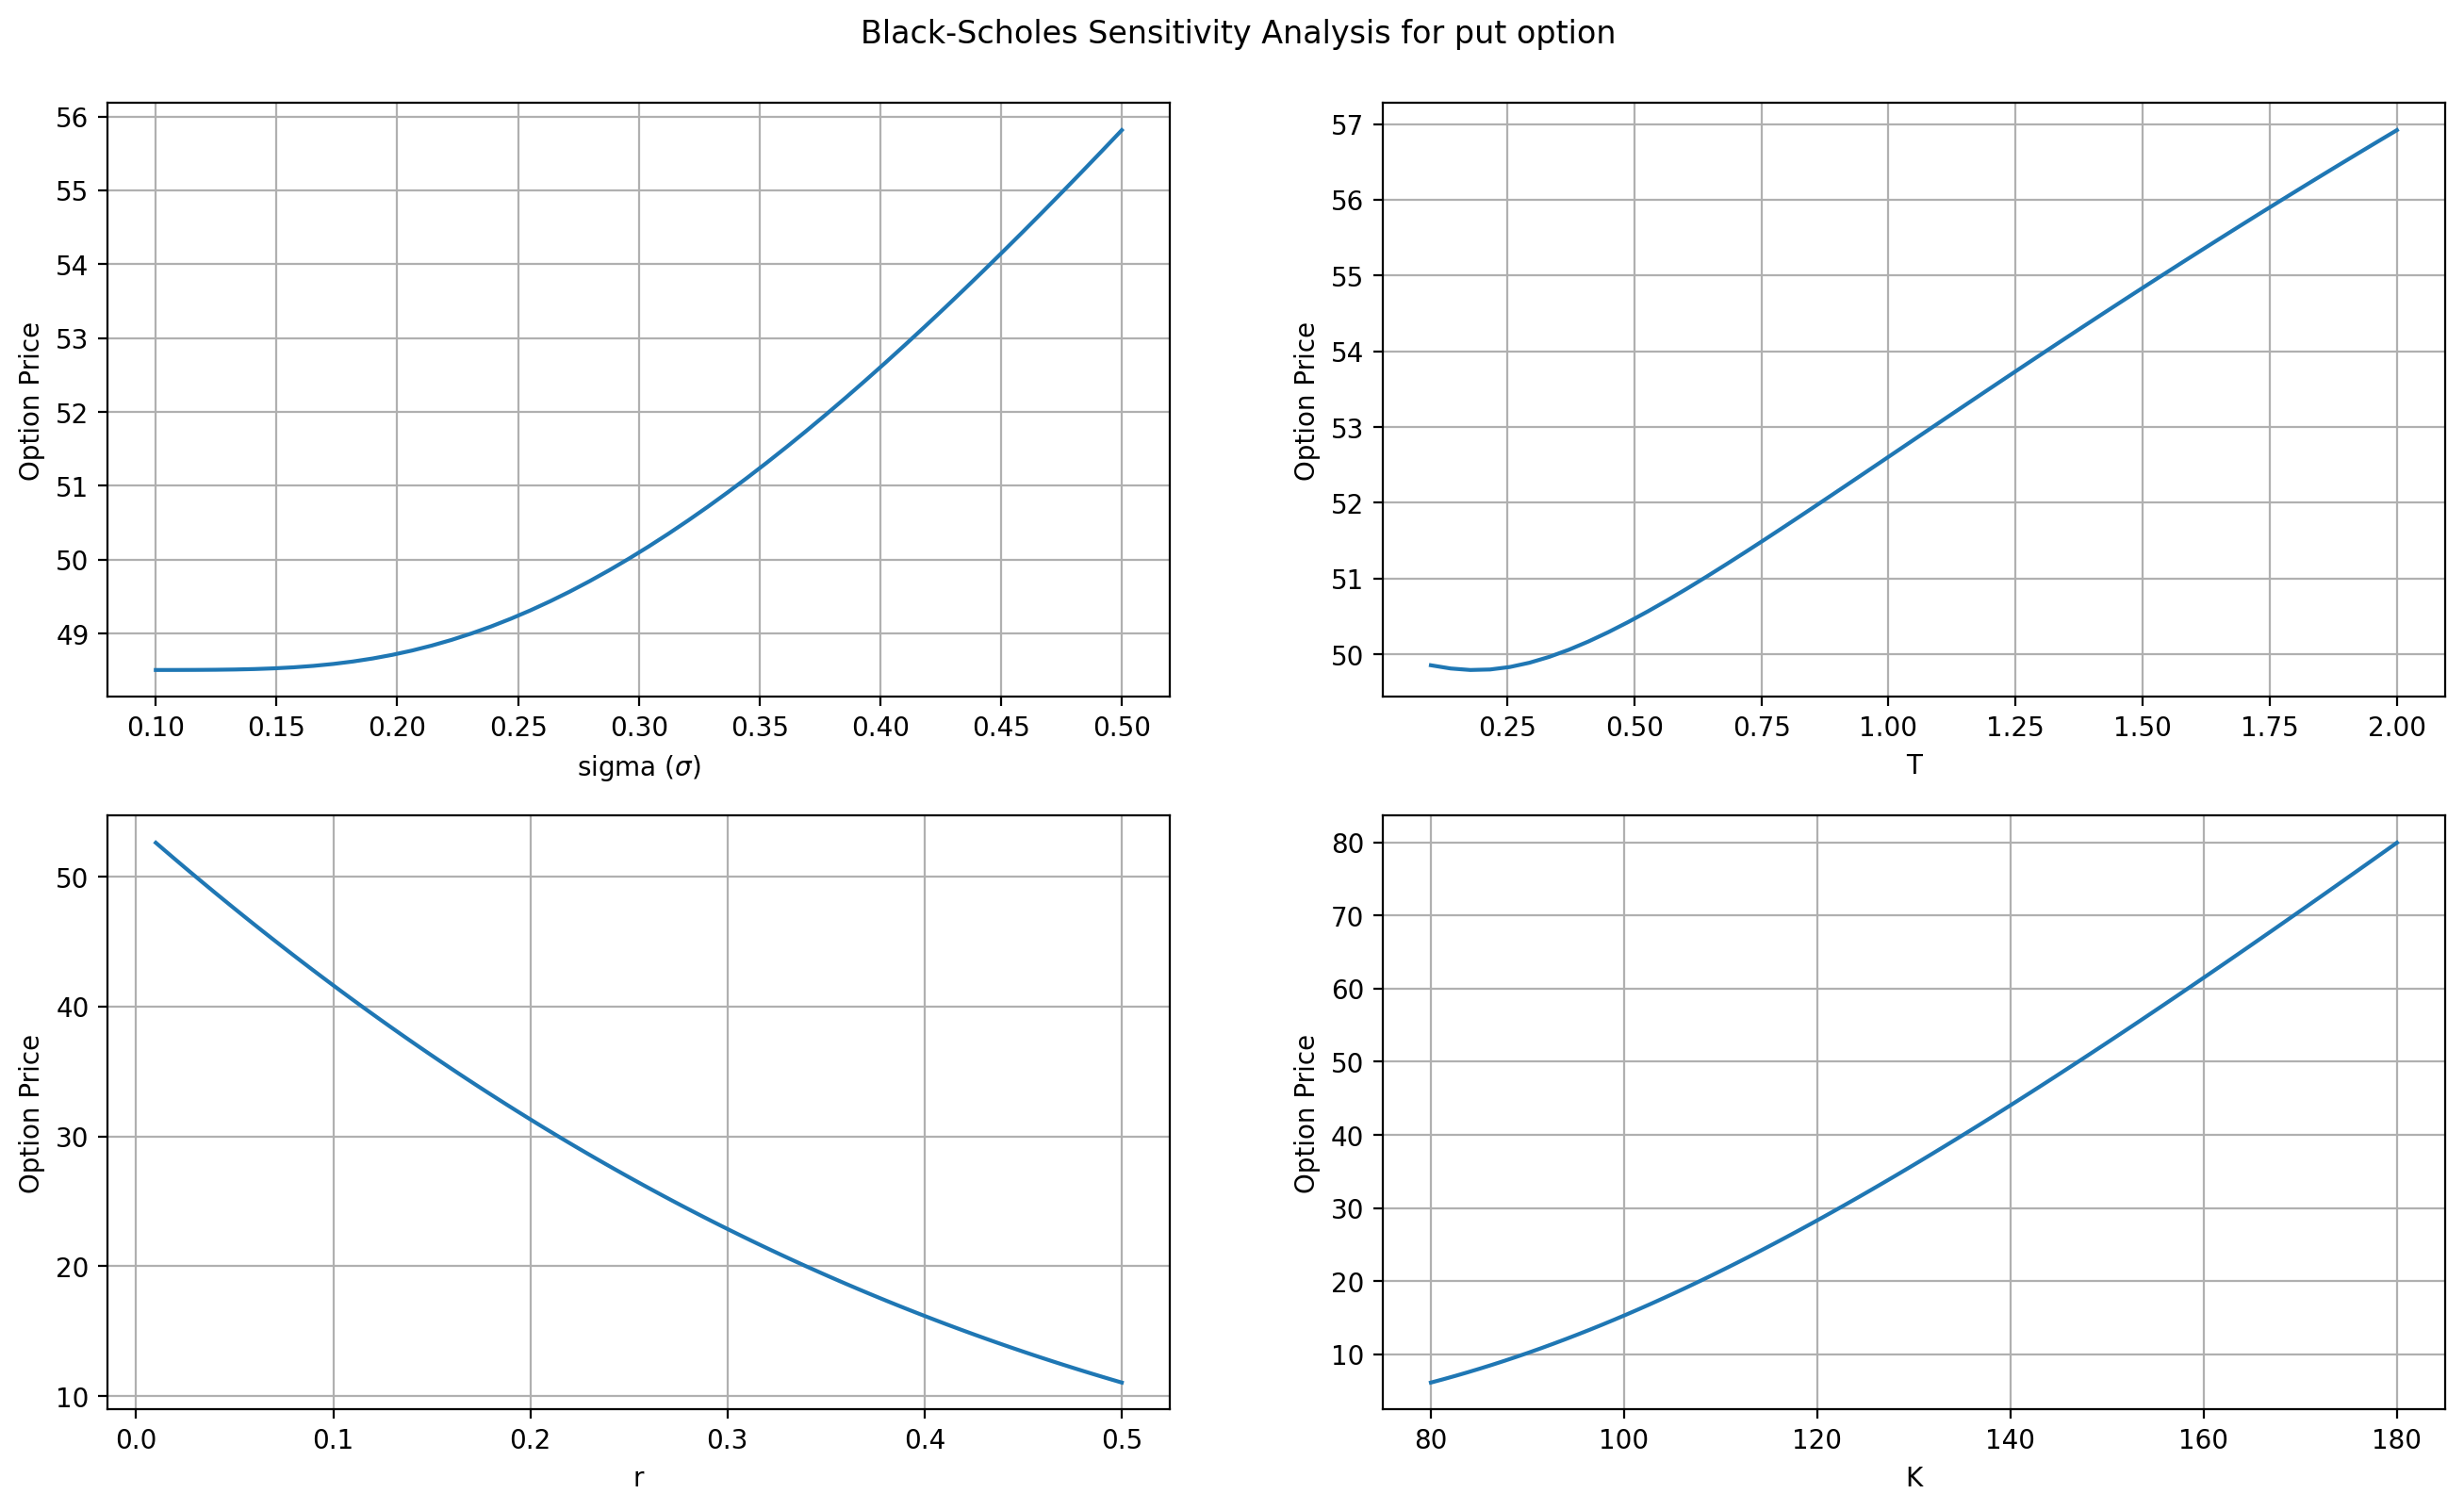

In [10]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

volatility_range = np.linspace(0.1, 0.5, 50)
black_scholes_sensitivity('sigma', volatility_range, S, K, T, r, sigma, 'put', axs[0, 0])

time_range = np.linspace(0.1, 2, 50)
black_scholes_sensitivity('T', time_range, S, K, T, r, sigma, 'put', axs[0, 1])

rate_range = np.linspace(0.01, 0.5, 100)
black_scholes_sensitivity('r', rate_range, S, K, T, r, sigma, 'put', axs[1, 0])

strike_range = np.linspace(80, 180, 80)
black_scholes_sensitivity('K', strike_range, S, K, T, r, sigma, 'put', axs[1, 1])

fig.suptitle(r'Black-Scholes Sensitivity Analysis for put option', y=0.93)
plt.show()

Again similar to binomial tree model, we see that for put option, option price increases as $\sigma, T, K$ increases and decreases as $r$ increases.

## **Convergence of pricing of Binomial Tree Model and Black-Scholes Model**

As the number of time steps $N$ increases, the binomial tree model price for European options converges to the Black-Scholes price. It converges because binomial tree model provides a discrete-time approximation to the continuous process underlying the Black-Scholes model, and as the number of time steps in the binomial tree increases, the discrete movements in the price that follow a binomial distribution approaches the log-normal distribution assumed by Black-Scholes.

To plot the price convergence, we fix the parameters and vary the number of time steps $N$ of binomial tree model and get the prices for each time step. We then plot the prices given by binomial tree and the Black-Scholes price (which is fixed) for both call and put options.



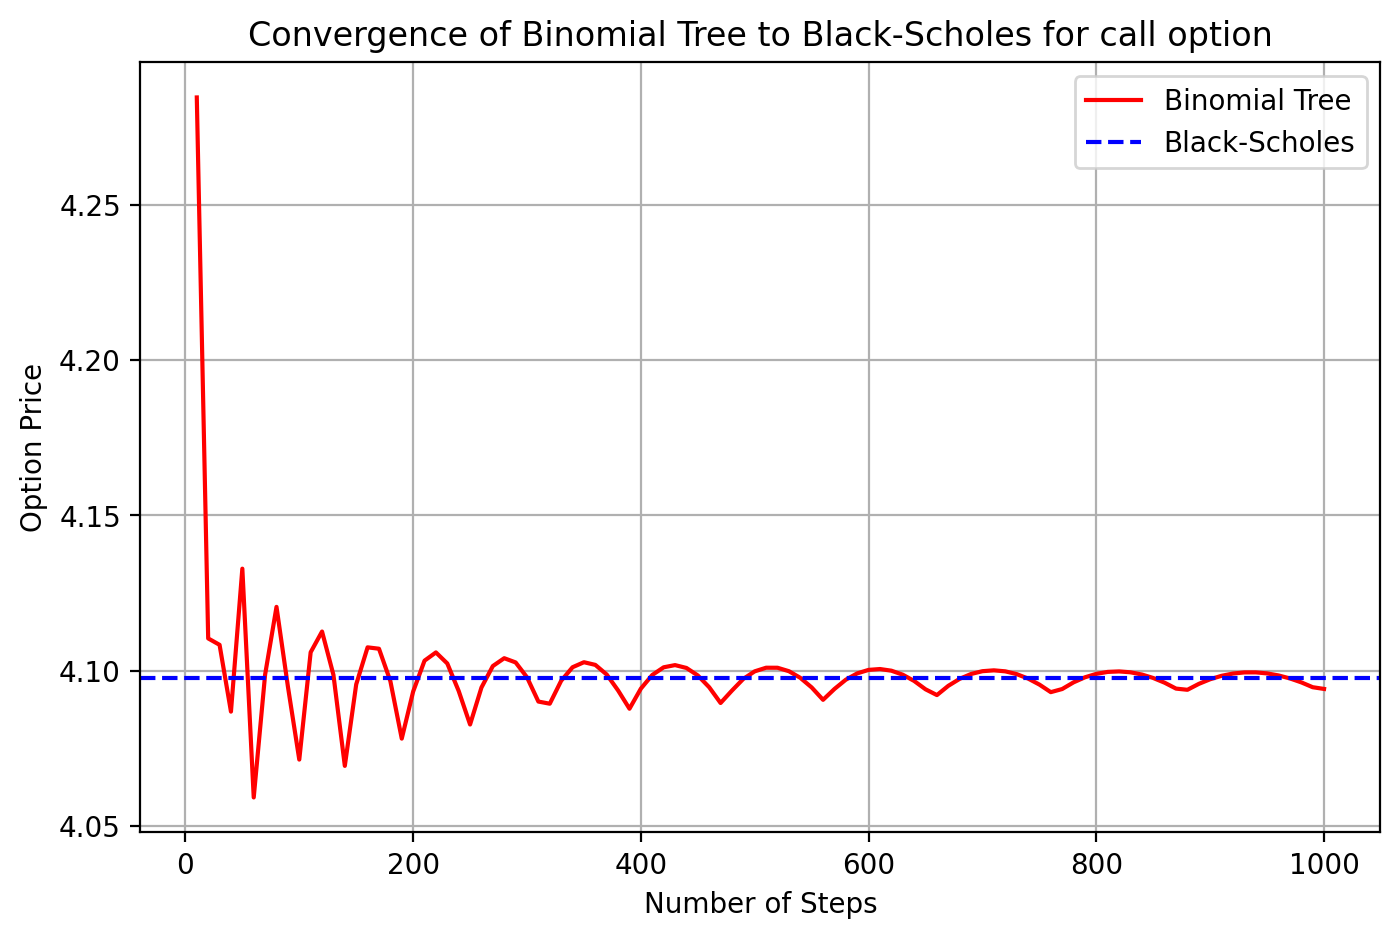

In [11]:
S = 100
K = 150
T = 1.0
r = 0.01
sigma = 0.4

bs_call = black_scholes_model(S, K, T, r, sigma, 'call')

steps = np.arange(10, 1001, 10)
bin_prices = []

for N in steps:
    price = binomial_tree_model(S, K, T, r, sigma, N, 'call')
    bin_prices.append(price)

plt.figure(figsize=(8, 5))
plt.plot(steps, bin_prices, 'r', label='Binomial Tree')
plt.axhline(y=bs_call, color='b', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes for call option')
plt.legend()
plt.grid(True)
plt.show()

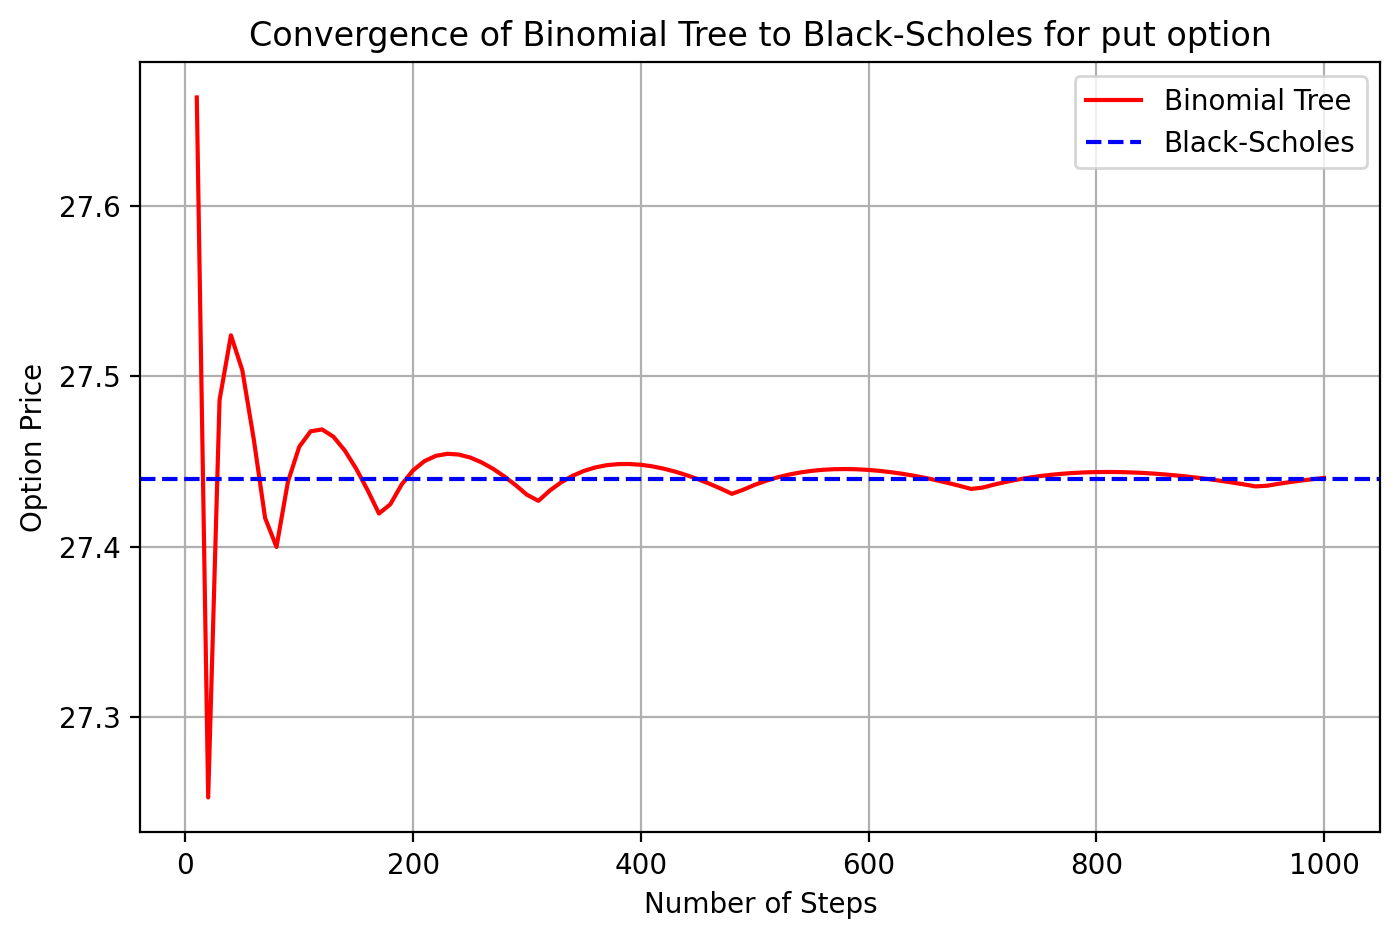

In [12]:
S = 100
K = 120
T = 1.0
r = 0.02
sigma = 0.4

bs_put = black_scholes_model(S, K, T, r, sigma, 'put')

steps = np.arange(10, 1001, 10)
bin_prices = []

for N in steps:
    price = binomial_tree_model(S, K, T, r, sigma, N, 'put')
    bin_prices.append(price)

plt.figure(figsize=(8, 5))
plt.plot(steps, bin_prices, 'r', label='Binomial Tree')
plt.axhline(y=bs_put, color='b', linestyle='--', label='Black-Scholes')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes for put option')
plt.legend()
plt.grid(True)
plt.show()

We see that there is oscillatory convergence: the binomial price oscillates around the Black-Scholes price as the number of time steps $N$ increases in both call and put cases. Also we see that after around 200-300 steps, the binomial price begins to settle close to the Black-Scholes value, and beyond 500-600 steps, the fluctuations are close to zero, showing the convergence improves with more time steps.

## **Evaluation on Real Market Data**

We will evaluate the models on Apple option chain for all available expiry dates. Here we use the mid price = (bid price + ask price)/2 for the real market price.
Note: For getting best results and more number of options, please run this cell around 7 PM to 8 PM IST as this is the time when US markets will open, and yfinance gives a lot of options during this time.

In [28]:
import yfinance as yf
from datetime import datetime

df_call_list = []
df_put_list = []

ticker = yf.Ticker('AAPL')
expiries = ticker.options

for expiry in expiries:
    option_chain = ticker.option_chain(expiry)

    for [option, df] in zip(['call', 'put'], [option_chain.calls, option_chain.puts]):
        df_filter = df[(df['bid'] > 0) & (df['ask'] > 0) & (df['impliedVolatility'] > 0.1) & (df['lastPrice'] > 0)].copy()

        if df_filter.empty:
            continue

        df_filter['ticker'] = 'AAPL'
        df_filter['stockPrice'] = ticker.info['regularMarketPrice']
        expiry_date = datetime.strptime(expiry, '%Y-%m-%d')
        current_date = datetime.now()
        T = (expiry_date - current_date).days / 365
        if T <= 0:
            continue;
        df_filter['expiry'] = T

        if option == 'call':
            df_call_list.append(df_filter)
        else:
            df_put_list.append(df_filter)

df_call = pd.concat(df_call_list, ignore_index=True)
df_put = pd.concat(df_put_list, ignore_index=True)

for df in [df_call, df_put]:
    df['mid price'] = (df['bid'] + df['ask'])/2

cols = ['ticker', 'stockPrice', 'expiry', 'strike', 'impliedVolatility', 'mid price']

df_call = df_call[cols].copy()
df_put = df_put[cols].copy()

We sort the options by mid price, so that it will become easy to visualize later.

In [29]:
df_call = df_call.sort_values(by='mid price', ascending=True).reset_index(drop=True)
df_put = df_put.sort_values(by='mid price', ascending=True).reset_index(drop=True)

Now for each call and put option, we compute the option price given by binomial tree model (where time steps is $N = 100$) and black scholes model. We also compute option greeks for each option. We assume the rate of interest is $r = 0.05$, which is close to the average U.S. Treasury yield over long periods of time. Note: 'bin' is binomial tree model and 'bs' is black scholes model.

In [30]:
for option, df in [('call', df_call), ('put', df_put)]:
    df['bin price'] = 0.0
    df['bs price'] = 0.0

    for index, row in df.iterrows():
        S = df.at[index, 'stockPrice']
        K = df.at[index, 'strike']
        T = df.at[index, 'expiry']
        sigma = df.at[index, 'impliedVolatility']
        r = 0.05

        df.at[index, 'bin price'] = binomial_tree_model(S, K, T, r, sigma, 100, option)
        df.at[index, 'bs price'] = black_scholes_model(S, K, T, r, sigma, option)

        greeks = black_scholes_greeks(S, K, T, r, sigma, option)
        for greek in greeks.keys():
            df.at[index, greek] = greeks[greek]

Here is a sample view of dataframe with all the prices and greeks calculated.

In [31]:
df_call.sample(5)

,ticker,stockPrice,expiry,strike,impliedVolatility,mid price,bin price,bs price,Delta,Gamma,Theta,Vega,Rho
584,AAPL,197.76,0.104110,170.0,0.478033,29.600,30.915281,30.924745,0.862475,0.007209,-39.194345,14.030937,14.537695
120,AAPL,197.76,0.161644,260.0,0.318366,0.180,0.197445,0.200196,0.022184,0.002088,-4.347962,4.202589,0.676802
81,AAPL,197.76,0.161644,275.0,0.341803,0.090,0.097414,0.103529,0.011550,0.001112,-2.648961,2.402342,0.352477
724,AAPL,197.76,0.008219,140.0,1.662111,58.250,57.909018,57.910454,0.991114,0.000807,-50.479400,0.430957,1.135004
642,AAPL,197.76,2.501370,205.0,0.357352,41.125,51.132430,51.066042,0.670126,0.003240,-12.162674,113.252528,203.756735


Now we plot how the prices computed by the models compare with the real prices.

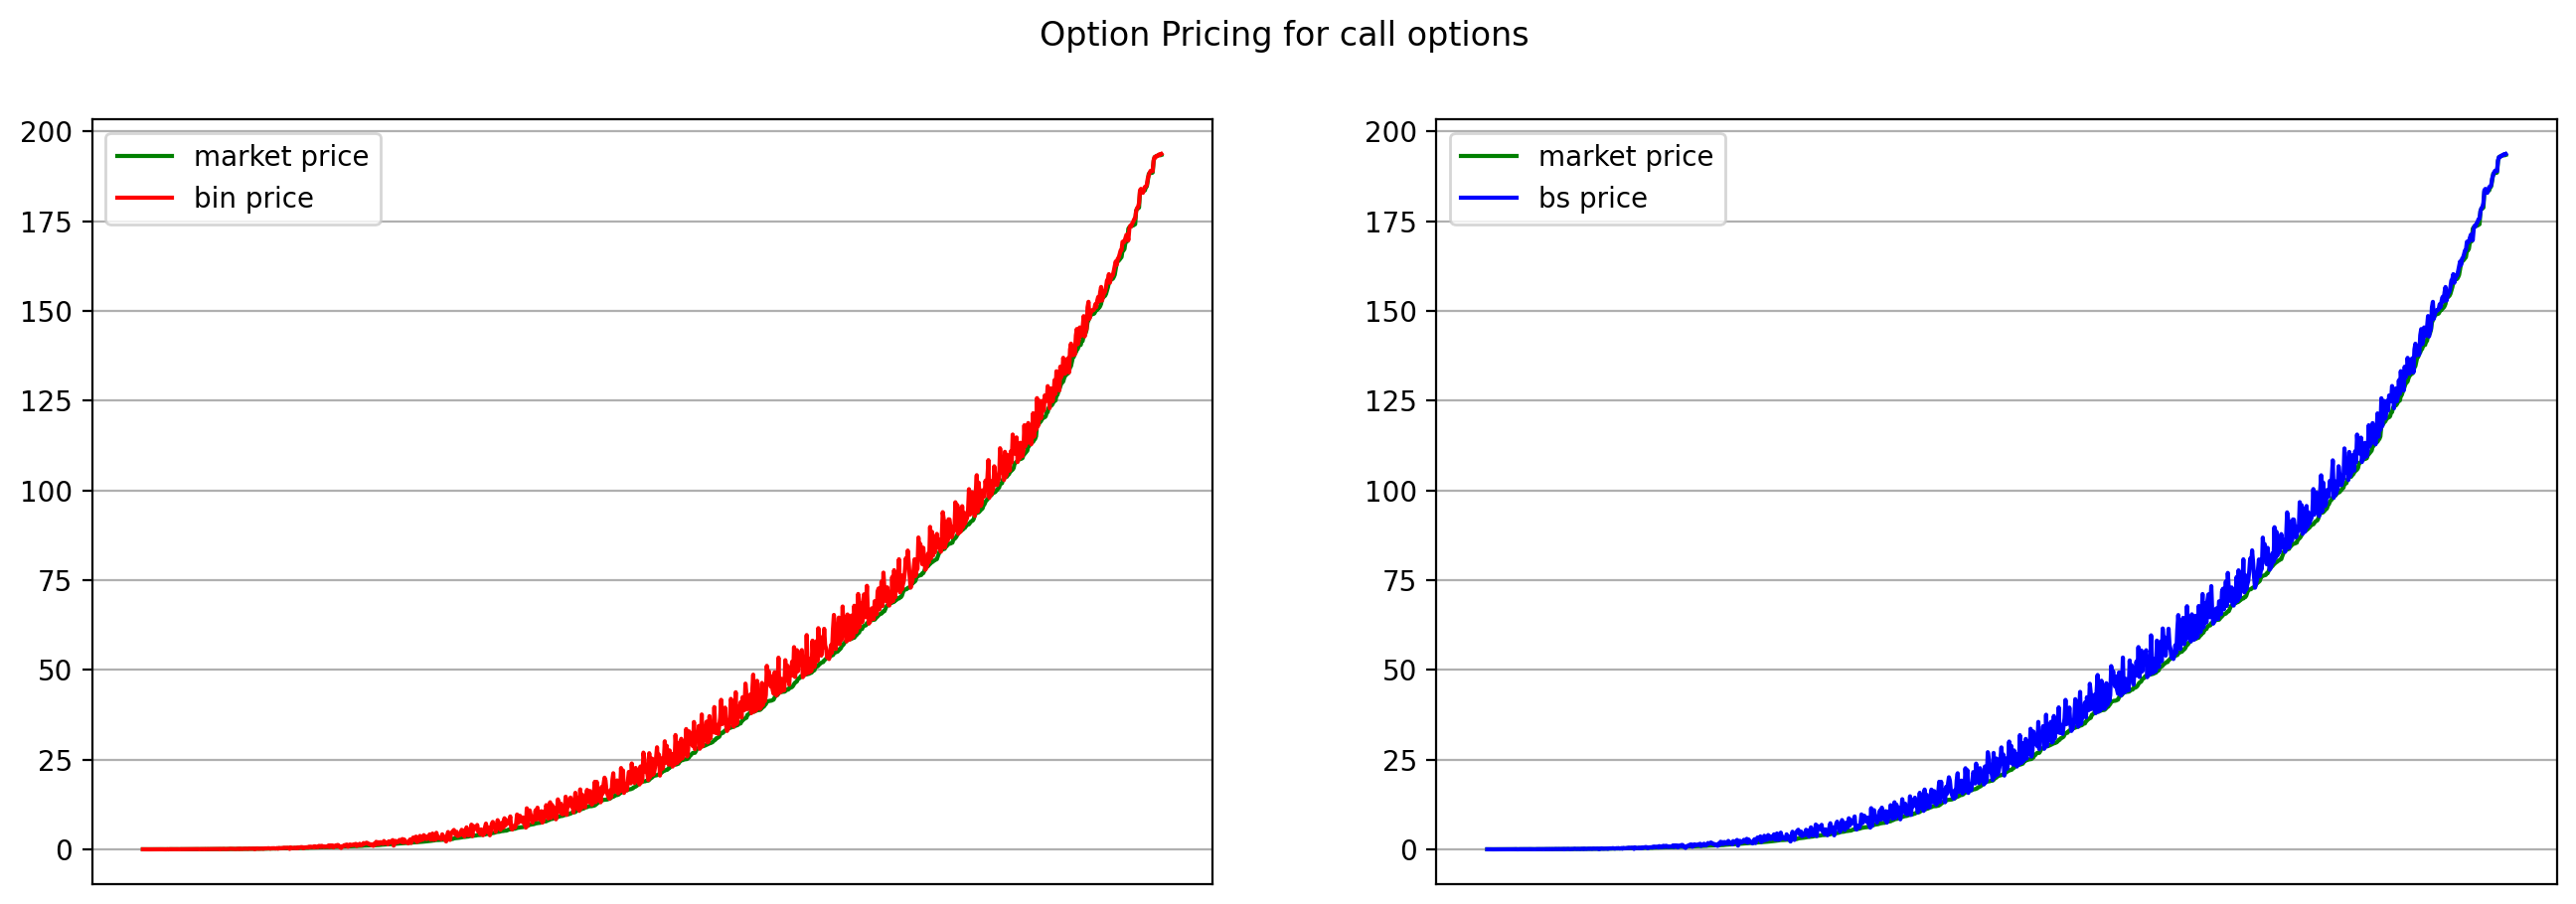

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(np.arange(len(df_call)), df_call['mid price'], 'g', label='market price')
axs[0].plot(np.arange(len(df_call)), df_call['bin price'], 'r', label='bin price')
axs[0].set_xticks([])
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.arange(len(df_call)), df_call['mid price'], 'g', label='market price')
axs[1].plot(np.arange(len(df_call)), df_call['bs price'], 'b', label='bs price')
axs[1].set_xticks([])
axs[1].legend()
axs[1].grid(True)

fig.suptitle("Option Pricing for call options")
plt.show()

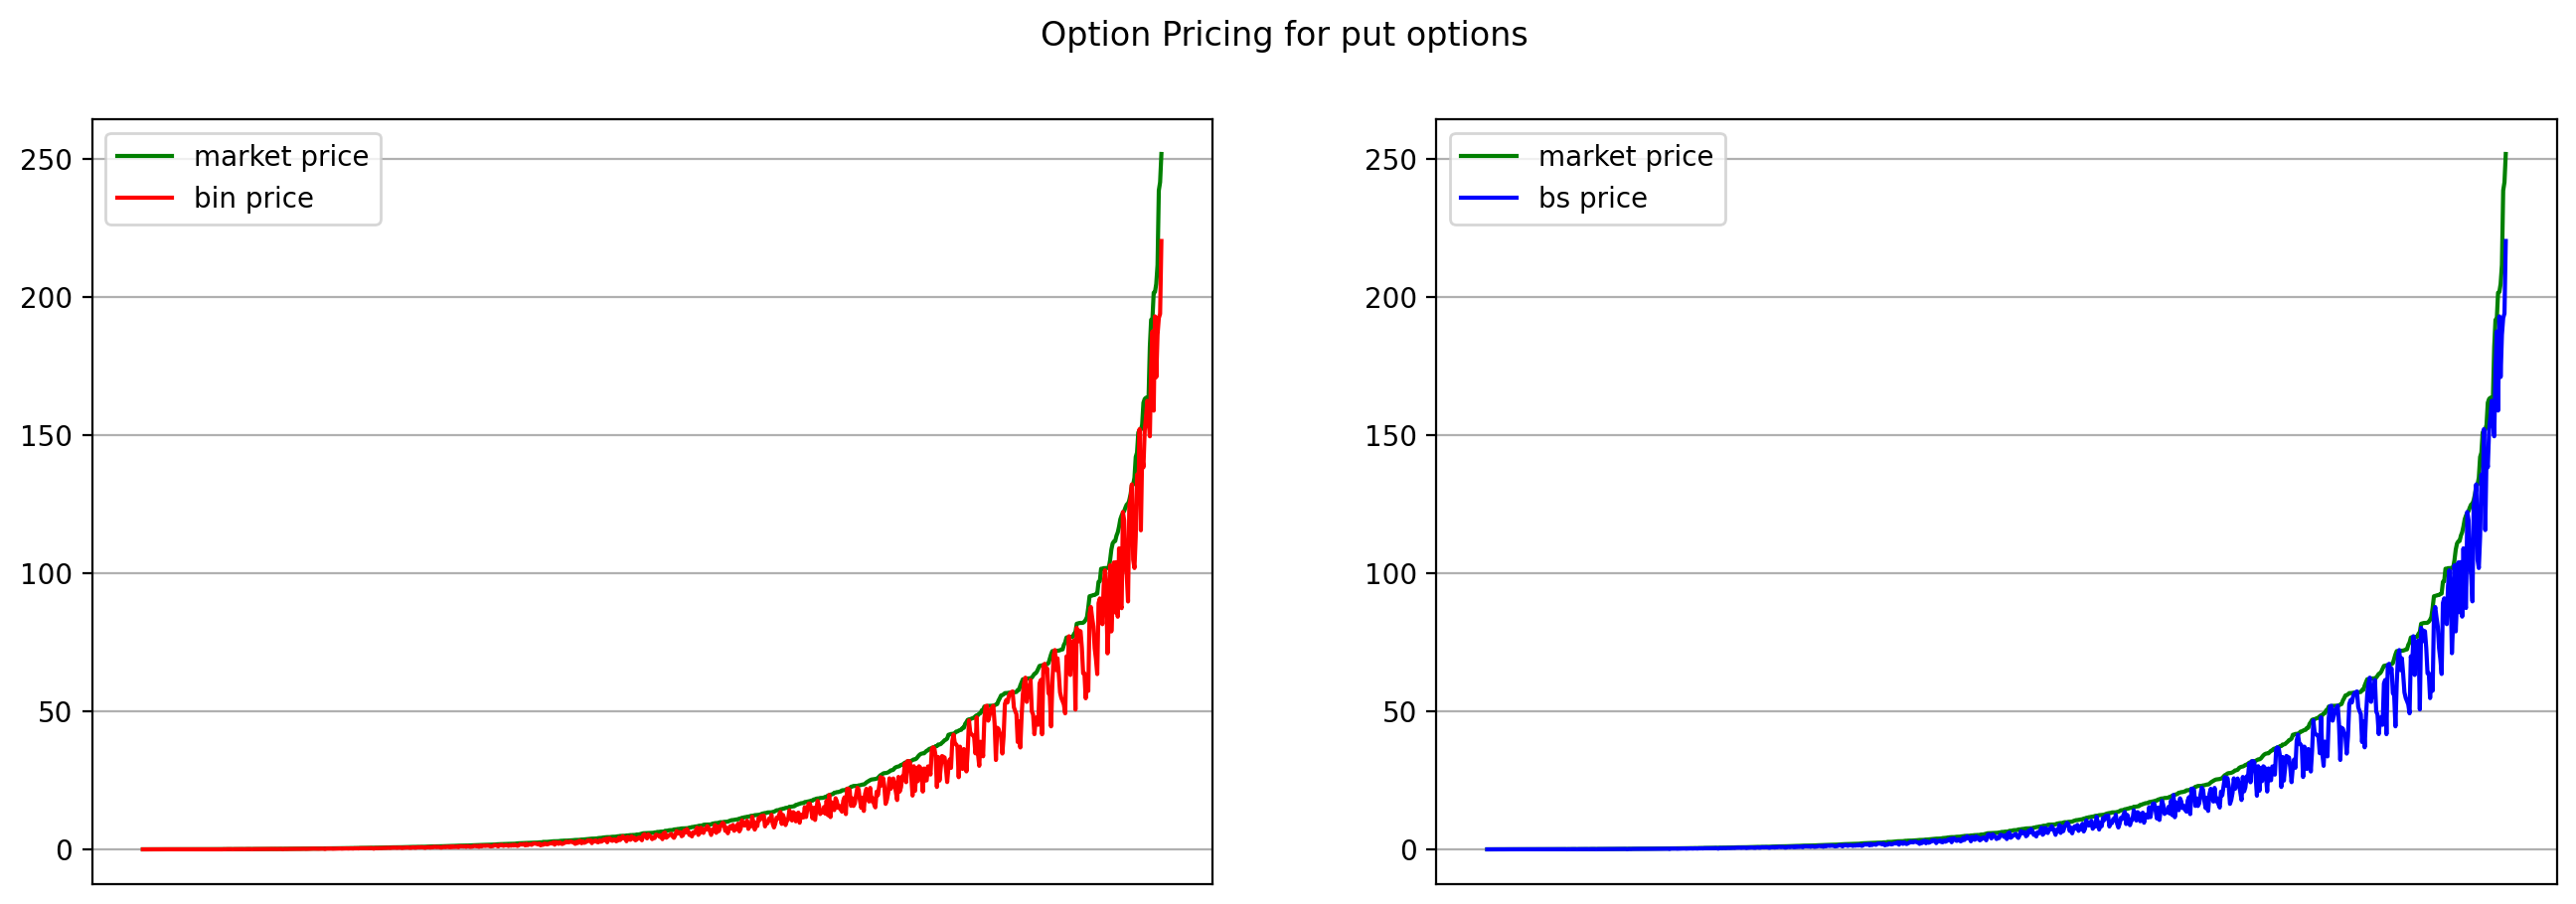

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(np.arange(len(df_put)), df_put['mid price'], 'g', label='market price')
axs[0].plot(np.arange(len(df_put)), df_put['bin price'], 'r', label='bin price')
axs[0].set_xticks([])
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.arange(len(df_put)), df_put['mid price'], 'g', label='market price')
axs[1].plot(np.arange(len(df_put)), df_put['bs price'], 'b', label='bs price')
axs[1].set_xticks([])
axs[1].legend()
axs[1].grid(True)

fig.suptitle("Option Pricing for put options")
plt.show()

Now we calculate the errors made by the models and compute the statistics of the errors (like mean, standard deviation etc.).

In [34]:
for df in [df_call, df_put]:
    df['bs error'] = abs(df['mid price'] - df['bs price'])
    df['bin error'] = abs(df['mid price'] - df['bin price'])

df_call[['bs error', 'bin error']].describe().T

,count,mean,std,min,25%,50%,75%,max
bs error,1049.0,2.204280,2.588606,0.000037,0.217593,1.120571,3.299598,10.913455
bin error,1049.0,2.203596,2.595290,0.000625,0.215582,1.111140,3.311675,10.957355


In [35]:
df_put[['bs error', 'bin error']].describe().T

,count,mean,std,min,25%,50%,75%,max
bs error,795.0,3.873139,6.884538,0.002674,0.149900,0.854075,4.310294,47.545902
bin error,795.0,3.875267,6.891223,0.003697,0.155263,0.859247,4.284894,47.633189


## **Performance Comparison report**

**Pricing Accuracy:** We see that both models have almost the same statistics of errors as seen from above. The binomial tree model used had $N = 100$ time steps, which gives prices almost the same as the black scholes model, hence the similar statistics of errors. But we see that each model prices the option as close as the real market prices, but not prefectly, since there are assumptions that each model has (like constant volaitlity and interest rates for black scholes model), which in reality is not the case.

**Computational efficiency:** The binomial tree model has a time complexity of $O(N^2)$ where $N$ is the number of steps, as per our implementation. This means the binomial tree model's time increases with $N$, making it inefficient for high-accuracy pricing. The black scholes model has a time complexity of $O(1)$ due to its closed form nature, making it extremely fast to calculate option prices.

Here is a sample code that calculates the time for getting option price for both models:

In [36]:
import time

S = 100
K = 120
T = 1.0
r = 0.02
sigma = 0.4

tic = time.time()
price = binomial_tree_model(S, K, T, r, sigma, 1000, 'call')
toc = time.time()

print(f"Time taken: {toc - tic:.6f} seconds")

Time taken: 0.105533 seconds


In [37]:
tic = time.time()
price = black_scholes_model(S, K, T, r, sigma, 'call')
toc = time.time()

print(f"Time taken: {toc - tic:.6f} seconds")

Time taken: 0.000931 seconds


We see that for $N = 1000$, black scholes model is relatively faster than binomial tree model.

**Error convergence:** Explanation and visualiazation already covered. In fact, error between pricing of binomial tree model and black scholes model decreases at the rate of $O(1/\sqrt{N})$ as the time steps $N$ increase.

**When to prefer what model:**

* Binomial Tree model: We prefer this model for more complex conditions for instance, when asset pays dividends and there are varying interest rates and volatility. This model can be more accurate in low-volatility or short-term scenarios where a few steps suffice.
* Black Scholes model: We prefer this if we want speed and efficiency. Also this is preferable for options without dividends and when volatility, interest rate are constant. If we want to find option greeks for analytical insights, this is the preferable model.

